In [38]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import json

In [39]:
from types import SimpleNamespace

paths = SimpleNamespace(
    summary="results/rnnprop_{}/summary.csv",
    config="results/rnnprop_{}/config.json",
    evaluation="results/rnnprop_{}/period_19.npz",
    evaluation_baseline="results/{}/period_19.npz",
    baseline="results/baseline_{}.npz")

In [98]:
full_names = {
    "adam": "Adam",
    "rmsprop": "RMSprop",
    "base": "switch(IL, ML)",
    "metaonly": "ML only",
    "2t": "switch((IL1 + IL2)/2, ML)",
    "2t_max": "switch(max(IL1, IL2), ML)",
    "ilsum": "a * IL + ML",
    "ilsum_reweight": "0.25a * IL + ML",
    "ilsum_2t": "a * max(IL1, IL2) + ML",
    "choice": "L2O = choice(Adam, RMSProp)",
    "adam_mlp": "Adam",
    "rmsprop_mlp": "RMSprop",
}

baselines = ["adam", "rmsprop", "adam_mlp", "rmsprop_mlp"]

colors = {
    # Baselines
    "adam": "tab:blue",
    "rmsprop": "tab:orange",
    "adam_mlp": "tab:blue",
    "rmsprop_mlp": "tab:orange",
    "choice": "tab:gray",
    # 1t
    "base": "tab:olive",
    "metaonly": "tab:purple",
    "ilsum": "tab:brown",
    "ilsum_reweight": "tab:pink",
    # 2t
    "2t": "tab:cyan",
    "2t_max": "tab:green",
    "ilsum_2t": "tab:red",
}

test_sets = {
    '1t': ["adam", "metaonly", "base", "ilsum", "ilsum_reweight"],
    '2t': ["adam", "rmsprop", "choice", "metaonly", "2t_max", "2t", "ilsum_2t"],
    'best': ["adam", "rmsprop", "choice", "2t_max", "ilsum_2t"],
    'mlp': ["adam_mlp", "rmsprop_mlp"]
}

keys = ["loss", "val_loss", "sparse_categorical_accuracy", "val_sparse_categorical_accuracy"]

In [83]:
def get_test(test):
    if test in baselines:
        return paths.baseline.format(test)
    elif test == 'choice':
        return "results/baseline_choice/period_19.npz"
    elif test.startswith("baseline"):
        return paths.evaluation_baseline.format(test)
    else:
        return paths.evaluation.format(test)

In [54]:
def plot_band(ax, x, y, label=None, color=None):
    """Plot mean and min-to-max color band for stacked data y."""
    lower, upper, mean = [f(y, axis=0) for f in [np.min, np.max, np.mean]]
    mean_line, = ax.plot(x, mean, label=label, color=color)
    ax.fill_between(x, lower, upper, alpha=0.25, color=mean_line.get_color())
    return mean_line

def plot_stats(tests, axs):
    if isinstance(tests, str):
        tests = test_sets[tests]
    for key in tests:
        d = np.load(get_test(key)) 
        for ax, val in zip([*axs[0], *axs[1]], keys):
            y_val = np.log(d[val]) if val.endswith("loss") else d[val]
            plot_band(
                ax, np.arange(20), y_val, label=full_names[key], color=colors[key])

    for ax in [*axs[0], *axs[1]]:
        ax.set_xticks(np.arange(20))
        ax.set_xlabel("Epoch")

    axs[1][1].legend()

    axs[0][0].set_ylabel("Log Training Loss")
    axs[0][1].set_ylabel("Log Validation Loss")
    axs[1][0].set_ylabel("Training Accuracy")
    axs[1][1].set_ylabel("Validation Accuracy")


In [53]:
def plot_phase(tests, ax):
    if isinstance(tests, str):
        tests = test_sets[tests]
    for t in tests:
        d = np.load(get_test(t))
        x = np.mean(d["sparse_categorical_accuracy"], axis=0)
        y = np.mean(d["val_sparse_categorical_accuracy"], axis=0)
        label = full_names[t]
        ax.quiver(
            x[:-1], y[:-1], x[1:] - x[:-1], y[1:] - y[:-1],
            width=0.002, headwidth=5, headlength=5, color=colors[t],
            scale_units="xy", angles="xy", scale=1, label=label)
    ax.legend()
    ax.set_xlabel("Train Accuracy")
    ax.set_ylabel("Validation Accuracy")

def plot_phase_loss(tests, ax):
    if isinstance(tests, str):
        tests = test_sets[tests]
    for t in tests:
        d = np.load(get_test(t))
        x = np.log(np.mean(d["loss"], axis=0))
        y = np.log(np.mean(d["val_loss"], axis=0))
        ax.quiver(
            x[:-1], y[:-1], x[1:] - x[:-1], y[1:] - y[:-1],
            width=0.002, headwidth=5, headlength=5, color=colors[t],
            scale_units="xy", angles="xy", scale=1, label=full_names[t])
    ax.legend()
    ax.set_xlabel("Log Train Loss")
    ax.set_ylabel("Log Validation Loss")


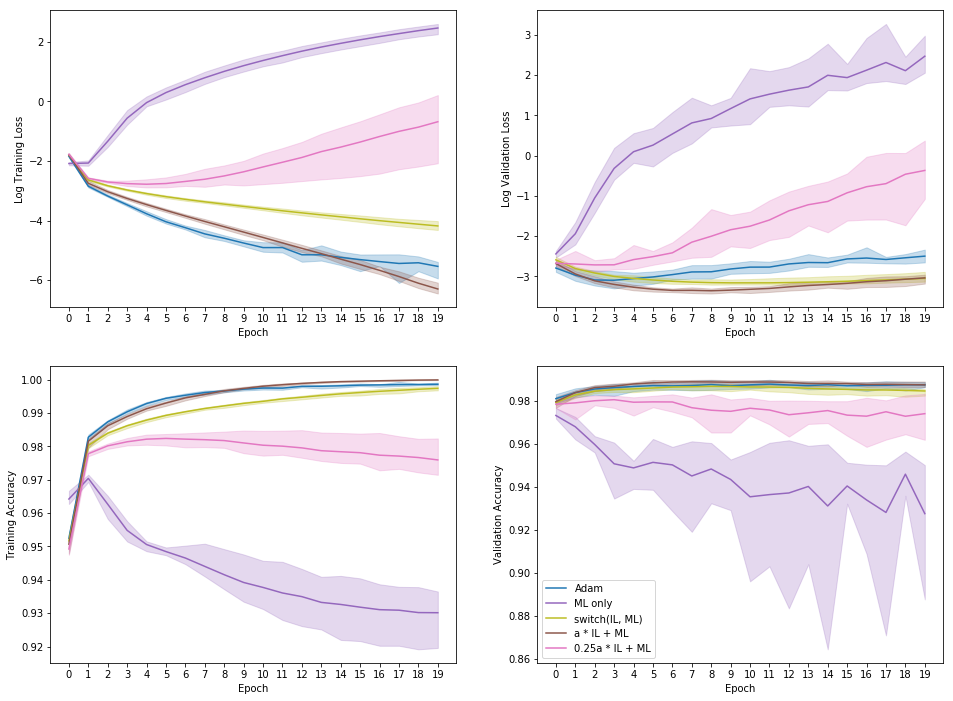

In [75]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
plot_stats("1t", axs)

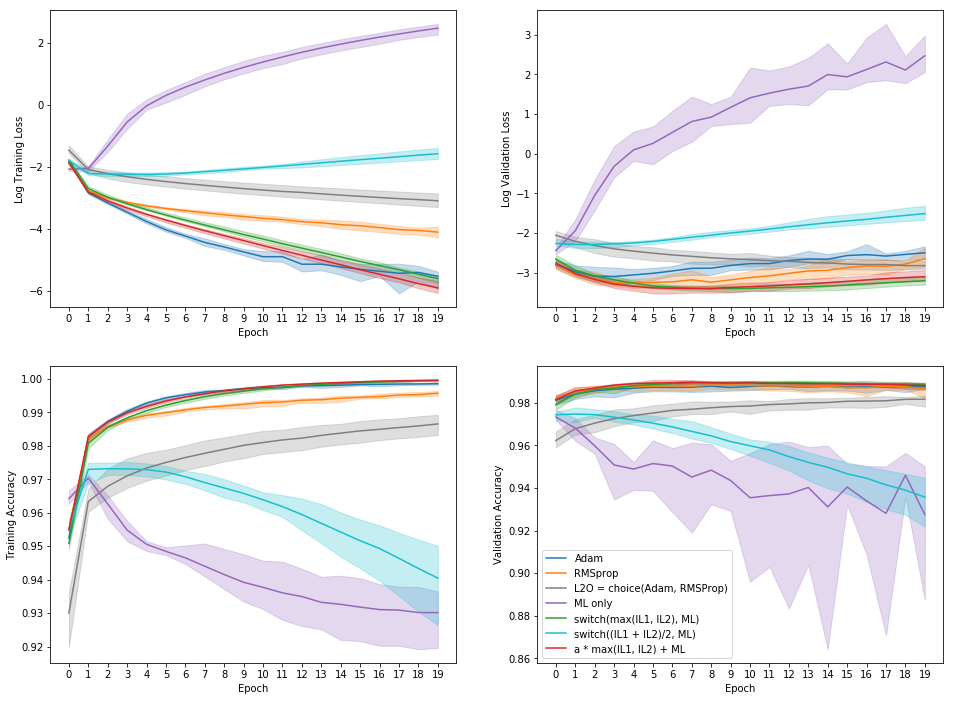

In [99]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
plot_stats("2t", axs)

(0.977, 0.991)

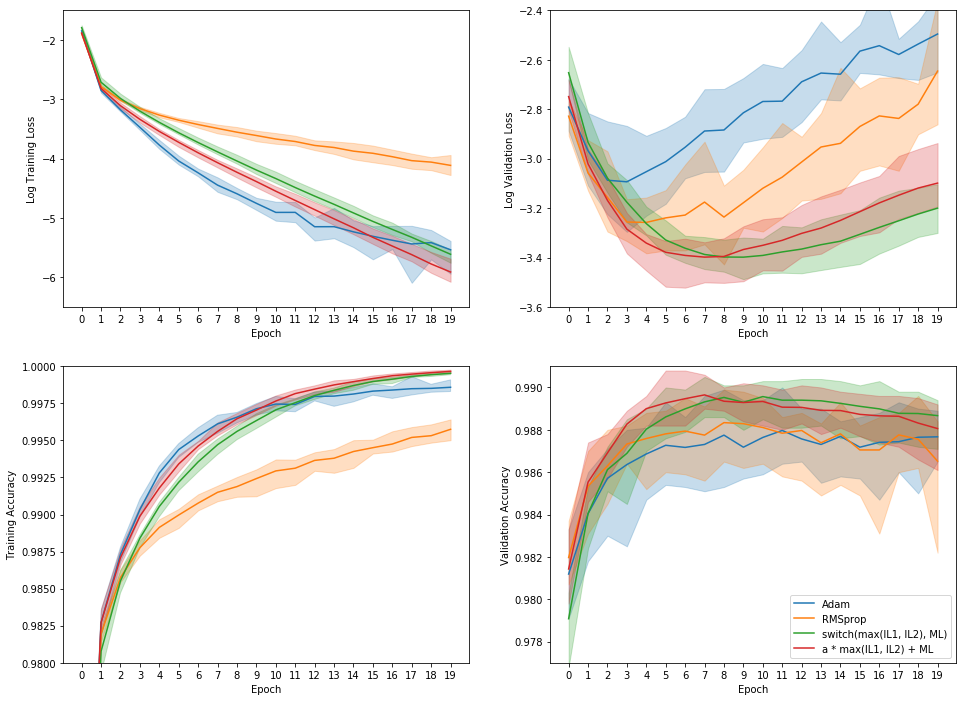

In [78]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
plot_stats("best", axs)
axs[0][0].set_ylim(-6.5, -1.5)
axs[0][1].set_ylim(-3.6, -2.4)
axs[1][0].set_ylim(0.98, 1)
axs[1][1].set_ylim(0.977, 0.991)


(-3.45, -2.8)

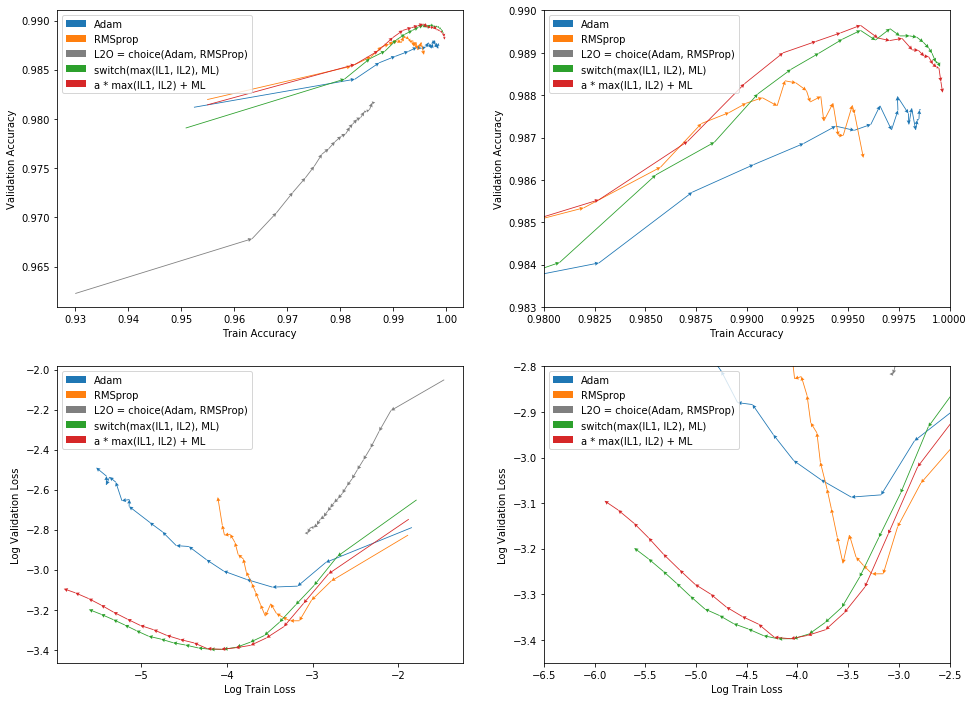

In [93]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

for row, pf in zip(axs, [plot_phase, plot_phase_loss]):
    pf("best", row[0])
    pf("best", row[1])

axs[0][1].set_xlim(0.980, 1.00)
axs[0][1].set_ylim(0.983, 0.99)
axs[1][1].set_xlim(-6.5, -2.5)
axs[1][1].set_ylim(-3.45, -2.8)

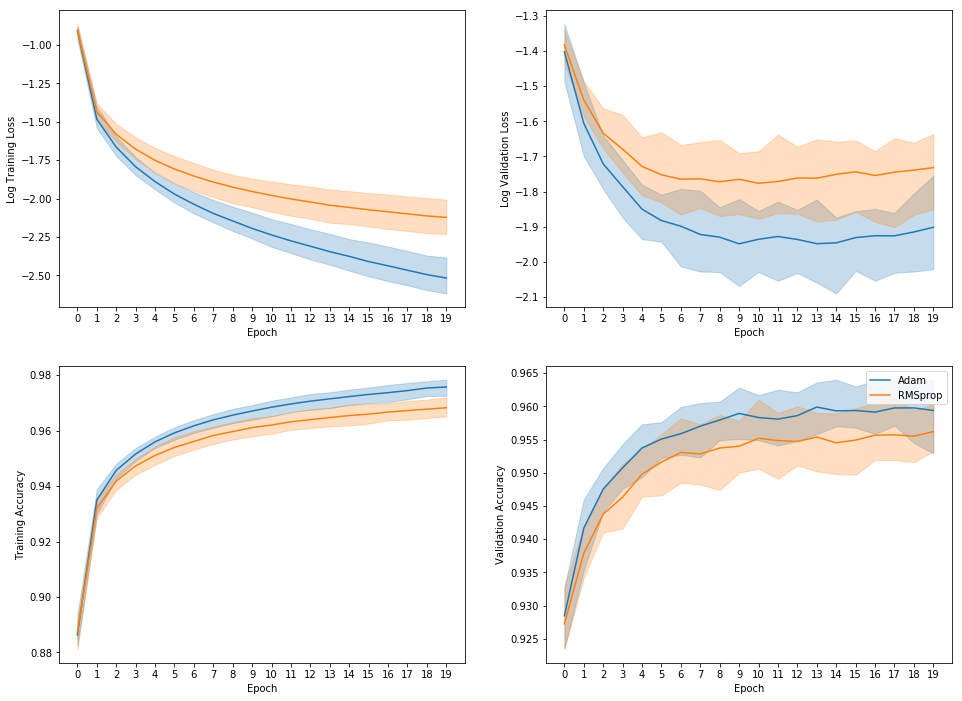

In [97]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
plot_stats("mlp", axs)